<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 10: Vectores autorregresivos (VAR)</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Simulación de un VAR(1)</div> 
</center>
<i>Creado:     2017-May-16 
    <br>
    Actualizado: 2020-Oct-25</i>

# Objetivo

En este cuaderno se presentan ejemplos de análisis de modelos VAR(1), con dos y tres variables.

En particular, el modelo VAR(1) de dos variables se representa como

\begin{align*} 
x_t &= c_1 + a_{11}x_{t-1} + a_{12}y_{t-1} + \epsilon_{x,t} \\
y_t &= c_2 + a_{21}x_{t-1} + a_{22}y_{t-1} + \epsilon_{y,t}
\end{align*}

y puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{c}{\begin{pmatrix}c_1 \\ c_2\end{pmatrix}} +
\underset{A}{\begin{pmatrix}a_{11} & a_{12} \\ a_{21} & a_{22}\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import multivariate_normal as mvn

np.random.seed(2020)

%matplotlib inline
sns.set_style("dark")

# Una clase para representar un VAR(1)

El trabajo se simplifica enormemente si creamos una clase para representar el VAR(1). En su implementación, definimos métodos para simularlo, determinar si es estable, y calcular la función de impulso respuesta. Para crear un objeto VAR(1), basta con pasarle a esta clase tres matrices: los interceptos, los coeficientes del rezago, y la varianza de los errores.

In [2]:
class VAR1:
    def __init__(self,c,A,omega):
        self.c = np.asarray(c)
        self.A = np.asarray(A)
        self.omega = np.asarray(omega)
        self.n = self.c.size
        self.names = ['x%d' % k for k in range(self.n)]
        self.shock = lambda : mvn(np.zeros(self.n), self.omega)
    
    def simulate(self, T=101):
        ''' Simula el VAR(1) T períodos'''
        X = np.zeros((T,self.n))
        try:
            X[0] = (np.linalg.inv(np.eye(2) - A) @ c).T
        except:
            pass
        
        for t in range(1, T):
            X[t] = self.c.T + X[t-1] @ self.A.T + self.shock()
        return pd.DataFrame(X, columns=self.names)
    
    def stability(self):
        ''' Determina la estabilidad del VAR a partir de los eigenvalores'''
        eigenvalues = np.linalg.eigvals(self.A)
        print('Los eigenvalores son ', eigenvalues)
        print('y sus módulos son', abs(eigenvalues))
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, polar=True)
        ax.plot(np.angle(eigenvalues), abs(eigenvalues),marker='o',linewidth=0)
        ax.set(ylim=[0,1], yticks=[1], yticklabels=[''], xticks=np.arange(4)*np.pi/2)
        
    def irf(self, h=40, unit=True, plot=True, **kwargs):
        ''' Calcula la función de impulso respuesta'''
        n = self.n
        
        impulse = np.eye(n) if unit else np.linalg.cholesky(self.omega)
        
        print('Los impulsos son ')
        for k in range(n):
            print(self.names[k],":  " ,impulse[:,k])
        
        X = np.zeros((h+1, n, n))
        X[0] = impulse
        for t in range(h):
            X[t+1] = self.A @ X[t]
        
        cols = [f'{y} --> {x}' for x in self.names for y in self.names]
        data = pd.DataFrame(X.reshape(h+1,n*n), columns=cols)
        if plot:
            data.plot(subplots=True, layout=(n,n), 
                      title='Impulse-response function',**kwargs)
        else:
             return data   
        
    def analysis(self, T=101, h=40, unit=True, plot=True, **kwargs):
        ''' Analiza el VAR: estabilidad, simulación, impulso-respuesta'''
        self.stability()
        self.simulate(T).plot(title="Simulated VAR(1) process")
        self.irf(h=h,unit=unit,plot=plot,**kwargs)

# Ejemplos

## MODELO 1

 \begin{align*} 
x_t &= 0.7x_{t-1} + 0.2y_{t-1} + \epsilon_{x,t} \\
y_t &= 0.2x_{t-1} + 0.7y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.7 & 0.2 \\ 0.2 & 0.7\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}
$$

Los eigenvalores son  [0.9 0.5]
y sus módulos son [0.9 0.5]
Los impulsos son 
x0 :   [1. 0.]
x1 :   [0. 1.]


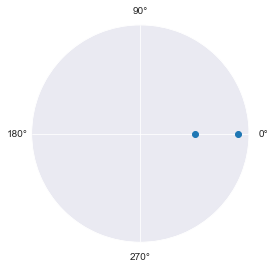

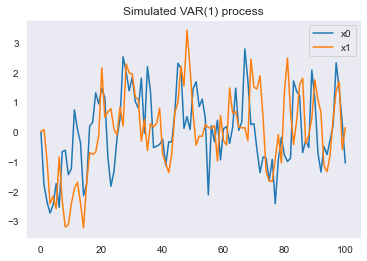

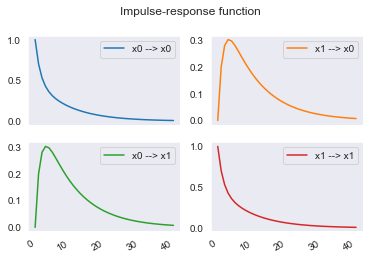

In [3]:
intercepto = [0, 0]
pendientes = [[0.7,0.2],[0.2, 0.7]]
omega = np.eye(2)

model1 = VAR1(intercepto,pendientes , omega)
model1.analysis()

## MODELO 2

 \begin{align*} 
x_t &= 0.5 + 0.5x_{t-1} + 0.5y_{t-1} + \epsilon_{x,t} \\
y_t &= 0.0 + 0.5x_{t-1} + 0.5y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{c}{\begin{pmatrix}0.5 \\ 0.0\end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.5 & 0.5 \\ 0.5 & 0.5\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}1.0 & -0.4 \\ -0.4 & 1.0\end{pmatrix}
$$

En este caso, el VAR tiene una raíz unitaria, por lo que no es estable. Observe como las funciones de impulso respuesta no regresan a cero.

Por otra parte, dado que la matriz $\Phi$ es idempotente, luego de un período la respuesta es constante.

Los eigenvalores son  [1.00000000e+00 1.11022302e-16]
y sus módulos son [1.00000000e+00 1.11022302e-16]
Los impulsos son 
x0 :   [1. 0.]
x1 :   [0. 1.]


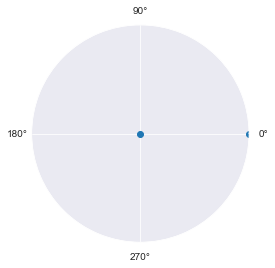

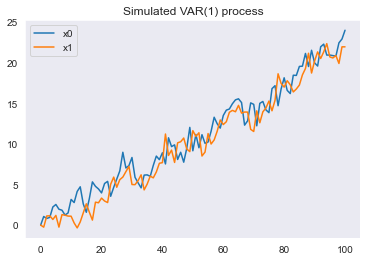

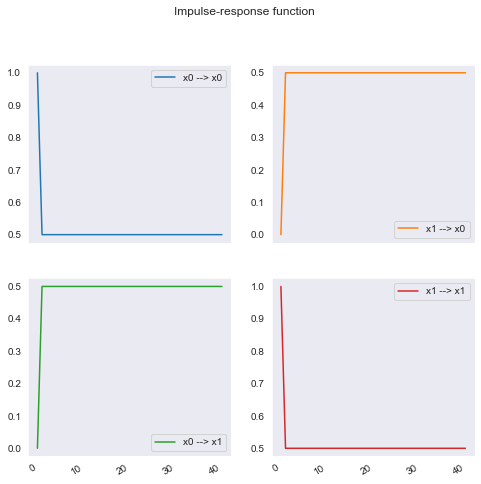

In [4]:
intercepto = [0.5, 0]
pendientes = [[0.5,0.5],[0.5, 0.5]]
omega = [[1,-0.4],[-0.4, 1]]

model2 = VAR1(intercepto, pendientes , omega)
model2.analysis(figsize=[8,8])

## MODELO 3
 \begin{align*} 
x_t &= 0.5 + 0.95x_{t-1} + 0.0y_{t-1} + \epsilon_{x,t} \\
y_t &= 0.0 + 0.2x_{t-1} + 0.7y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{c}{\begin{pmatrix}0.5 \\ 0.0\end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.95 & 0.0 \\ 0.2 & 0.7\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}2.0 & -0.4 \\ -0.4 & 1.0\end{pmatrix}
$$

En este caso, el VAR tiene ambas raíces dentro del círculo unitario, por lo que es estable. La mayor de las raíces tiene un valor cercano a uno, por lo que las respuestas a los impulsos tienden a ser muy persistentes. 

Los eigenvalores son  [0.7  0.95]
y sus módulos son [0.7  0.95]
Los impulsos son 
x0 :   [1. 0.]
x1 :   [0. 1.]


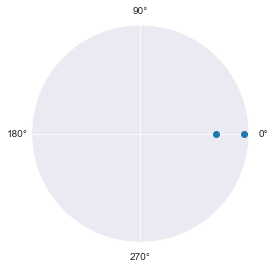

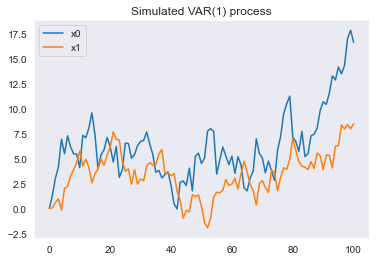

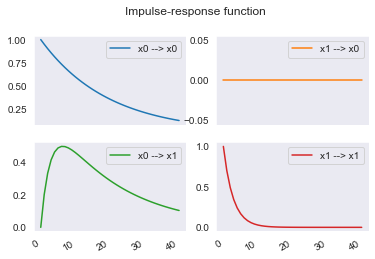

In [5]:
intercepto = [0.5, 0]
pendientes = [[0.95,0.0],[0.2, 0.7]]
omega = [[2,-0.4],[-0.4, 1]]

model3 = VAR1(intercepto,pendientes , omega)
model3.analysis()

Los impulsos en la gráfica anterior son unitarios. Ahora, graficamos la impulso respuesta para impulsos de una desviación estándar a partir de la descomposición de Cholesky de la matriz varianza covarianza.

Los impulsos son 
x0 :   [ 1.41421356 -0.28284271]
x1 :   [0.        0.9591663]


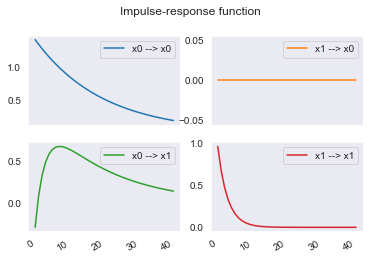

In [6]:
model3.irf(unit=False)

## MODELO 4
 \begin{align*} 
x_t &= 2.0 + 0.5x_{t-1} + 0.0y_{t-1} + 1.0z_{t-1} + \epsilon_{x,t} \\
y_t &= 1.0 + 0.1x_{t-1} + 0.1y_{t-1} + 0.3z_{t-1} + \epsilon_{y,t} \\
z_t &= 1.5 + 0.0x_{t-1} + 0.2y_{t-1} + 0.3z_{t-1} + \epsilon_{z,t} 
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t \\ z_t \end{pmatrix}} = 
\underset{c}{\begin{pmatrix}2.0 \\ 1.0\\ 1.5 \end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.5 & 0 & 1\\ 0.1 & 0.1 & 0.3\\0 & 0.2 & 0.3\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1} \\ z_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\\ \epsilon_{z,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}1 & 0.5 & -1 \\ 0.5 & 4.25 & 2.5\\ -1 &  2.5 & 12.25\end{pmatrix}
$$

En este caso, el VAR tiene sus tres raíces dentro del círculo unitario, por lo que es estable. La mayor de las raíces en valor absoluto es 0.65, por lo que las respuestas a los impulsos son menos persistentes que en el ejemplo anterior.

Los eigenvalores son  [0.65046644 0.03599765 0.21353591]
y sus módulos son [0.65046644 0.03599765 0.21353591]
Los impulsos son 
x0 :   [ 1.   0.5 -1. ]
x1 :   [0.  2.  1.5]
x2 :   [0. 0. 3.]


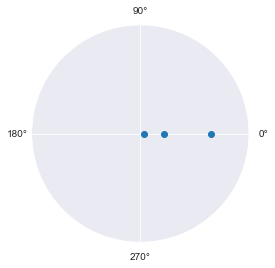

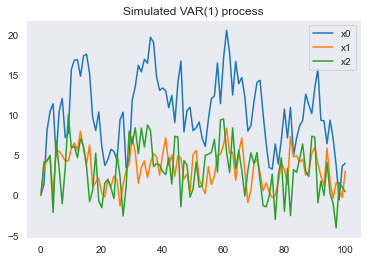

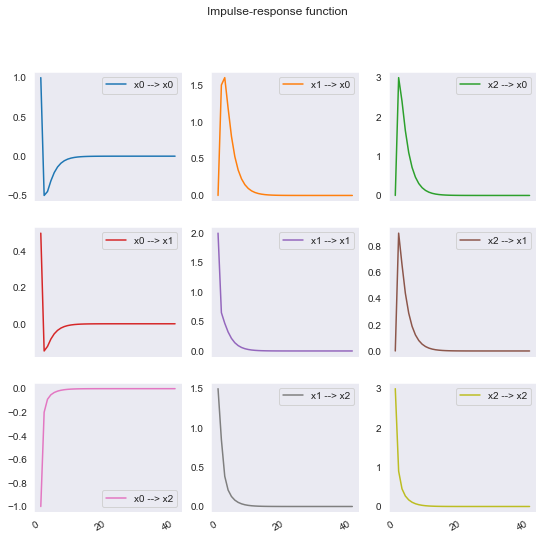

In [7]:
intercepto = [2, 1, 1.5]
pendientes = [[0.5,0, 1],[0.1, 0.1,0.3],[0,0.2,0.3]]
omega = [[1,0.5,-1],[0.5, 4.25, 2.5],[-1.00,2.5,12.25]]

model4 = VAR1(intercepto,pendientes , omega)
model4.analysis(figsize=[9,9], unit=False)

## MODELO 5
 \begin{align*} 
x_t &= 2.0 + 0.5x_{t-1} - 0.75y_{t-1} + 4.0z_{t-1} + \epsilon_{x,t} \\
y_t &= 1.0 - 0.2x_{t-1} + 0.1y_{t-1} + 0.3z_{t-1} + \epsilon_{y,t} \\
z_t &= 1.5 - 1.0x_{t-1} + 0.2y_{t-1} + 0.5z_{t-1} + \epsilon_{z,t} 
\end{align*}

que puede escribirse
$$
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t \\ z_t \end{pmatrix}} = 
\underset{c}{\begin{pmatrix}2.0 \\ 1.0\\ 1.5 \end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.5 & -0.75 & 4\\ -0.2 & 0.1 & 0.3\\ -0.1 & 0.2 & 0.5\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1} \\ z_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\\ \epsilon_{z,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}1 & 0.5 & -1 \\ 0.5 & 4.25 & 2.5\\ -1 &  2.5 & 12.25\end{pmatrix}
$$

En este caso, el VAR tiene sus tres raíces dentro del círculo unitario, por lo que es estable. Las mayores de las raíces en valor absoluto son complejas con módulo 0.907, por lo que las respuestas a los impulsos oscilan alrededor del eje horizontal.

Los eigenvalores son  [ 0.65776641+0.62520704j  0.65776641-0.62520704j -0.21553281+0.j        ]
y sus módulos son [0.90749132 0.90749132 0.21553281]
Los impulsos son 
x0 :   [ 1.   0.5 -1. ]
x1 :   [0.  2.  1.5]
x2 :   [0. 0. 3.]


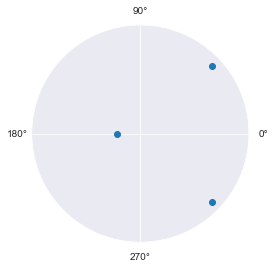

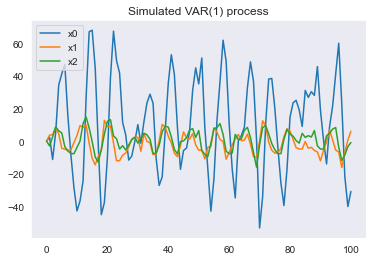

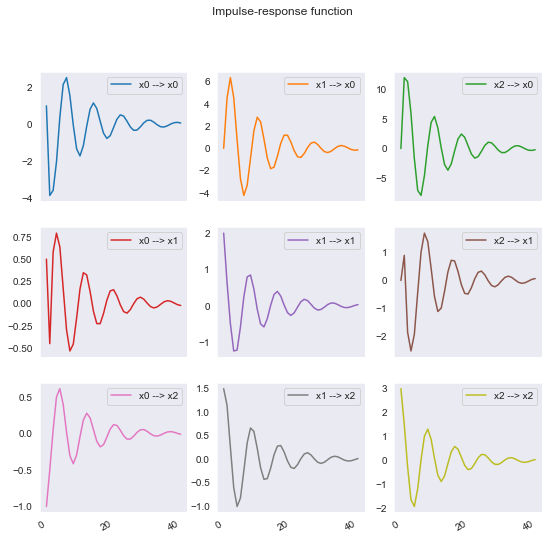

In [8]:
intercepto = [2, 1, 1.5]
omega = [[1,0.5,-1],[0.5, 4.25, 2.5],[-1.00,2.5,12.25]]

pendientes = [[0.5,-0.75, 4],[-0.2, 0.1,0.3],[-0.1,0.2,0.5]]
model5 = VAR1(intercepto,pendientes , omega)
model5.analysis(unit=False, figsize=[9,9])